# TUTORIAL: Real-time data assimilation on the Rijke tube


## Augmented state 

We perform state and parameter estimation in the RRijke tube model presented in [tutorial 05](05_Rijke_model.ipynb). 
The augmented state space vector of the Rijke tube model is
$$
\boldsymbol{\psi} = \begin{bmatrix}
        \boldsymbol{\phi}\\
        \boldsymbol{\alpha}\\
        \mathbf{p}_{mic}
        \end{bmatrix}
        =
        \begin{bmatrix}
        \boldsymbol{\eta} \\ 
        \boldsymbol{\mu} \\ 
        \boldsymbol{\nu} \\ 
        \beta\\
        \tau\\
        \mathbf{p}_{mic}
        \end{bmatrix}
        \in \mathbb{R}^{2N_m+N_c+2+N_q},
$$
where 
- $\boldsymbol{\eta}\in \mathbb{R}^{N_m}$: acoustic velocity modes (from Galerkin projection)
- $\boldsymbol{\mu}\in \mathbb{R}^{N_m}$: acoustic pressure modes (from Galerkin projection)
- $\boldsymbol{\nu}\in \mathbb{R}^{N_c}$: advection "velocity" modes (from Chevyshev projection)
- $\beta$: heat source strength
- $\tau$: acoustic time delay
- $\mathbf{p}_{mic} \mathbb{R}^{N_q}$: acoustic pressure at the microphone locations computed as
$$
{p}_{mic}(x_q, t) = -\sum^{N_m}_{j=1}\,\mu_j(t)\sin{\left(\dfrac{\omega_j}{\bar{c}} x_q\right)}. 
$$


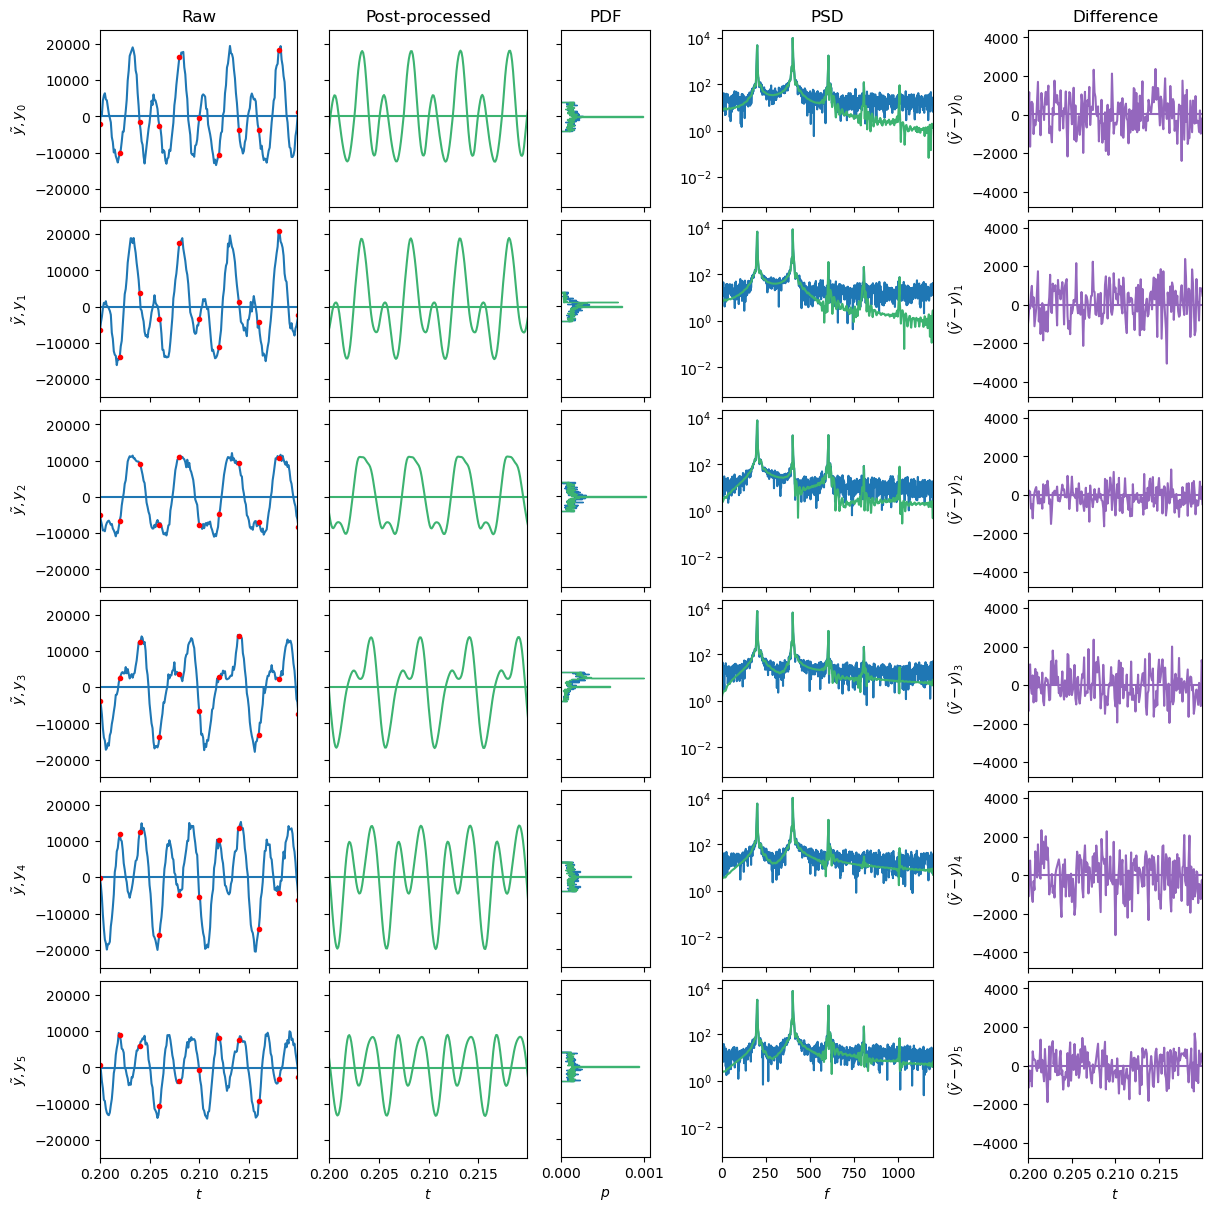

In [ ]:
from src.models_physical import Rijke
from src.create import create_truth
from src.plot_results import plot_truth

truth = create_truth(model=Rijke,
                     t_start=.2, 
                     t_stop=.6,
                     dt_obs=20,
                    beta=3.2, 
                    tau=1.2e-3)

plot_truth(**truth, f_max=1200, window=0.02, fig_width=12)


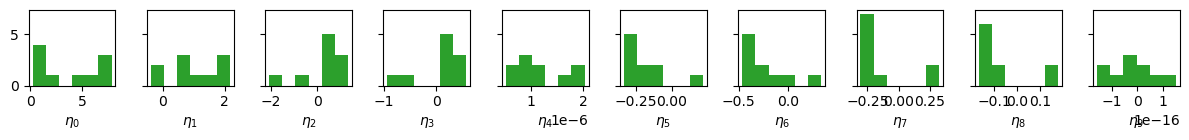

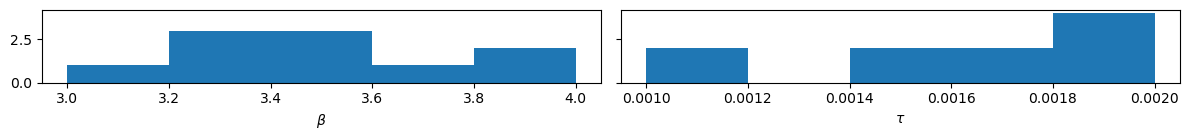

In [3]:
from src.create import create_ensemble
from src.plot_results import plot_ensemble


ensemble = create_ensemble(model=Rijke,
                           filter='EnKF',  # 'rBA_EnKF' 'EnKF' 'EnSRKF'
                           est_a=['beta', 'tau'],
                           std_a=dict(beta=[3., 4.], 
                                      tau=[1e-3, 2e-3]),
                           std_psi=0.25,
                           reject_inflation=1.005,
                           m=10
                           )
plot_ensemble(ensemble, max_modes=10)

In [4]:
from src.data_assimilation import dataAssimilation


filter_ens = ensemble.copy()
filter_ens.inflation = 1.

filter_ens = dataAssimilation(filter_ens, 
                              y_obs=truth['y_obs'], t_obs=truth['t_obs'], std_obs=0.1, 
                              Nt_extra=int(10*ensemble.t_CR // ensemble.dt))


 ------------------ Rijke Model Parameters ------------------ 
	 C1 = 0.050000
	 C2 = 0.010000
	 L = 1.000000
	 Nc = 50
	 Nm = 10
	 beta = 4.000000
	 kappa = 100000.000000
	 law = sqrt
	 tau = 0.001500
	 xf = 0.200000

 ---------------- NoBias bias model input_parameters --------------- 
	 N_ens = 1
	 bayesian_update = False
	 upsample = 1

 -------------------- ASSIMILATION PARAMETERS -------------------- 
 	 Filter = EnKF 
 	 Bias = NoBias 
 	 m = 10 
 	 Time steps between analysis = 20 
 	 Inferred params = ['beta', 'tau'] 
 	 Inflation = 1.0 
 	 Reject Inflation = 1.005 
 	 Ensemble std(psi0) = 0.25
 	 Ensemble std(alpha0) = {'beta': [3.0, 4.0], 'tau': [0.001, 0.002]}
 	 Number of analysis steps = 200, t0=0.2, t1=0.598
Elapsed time to first observation: 1.979551076889038 s
Assimilation progress: 
	0 % 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% ----------------

Elapsed time during assimilation: 8.625196695327759 s


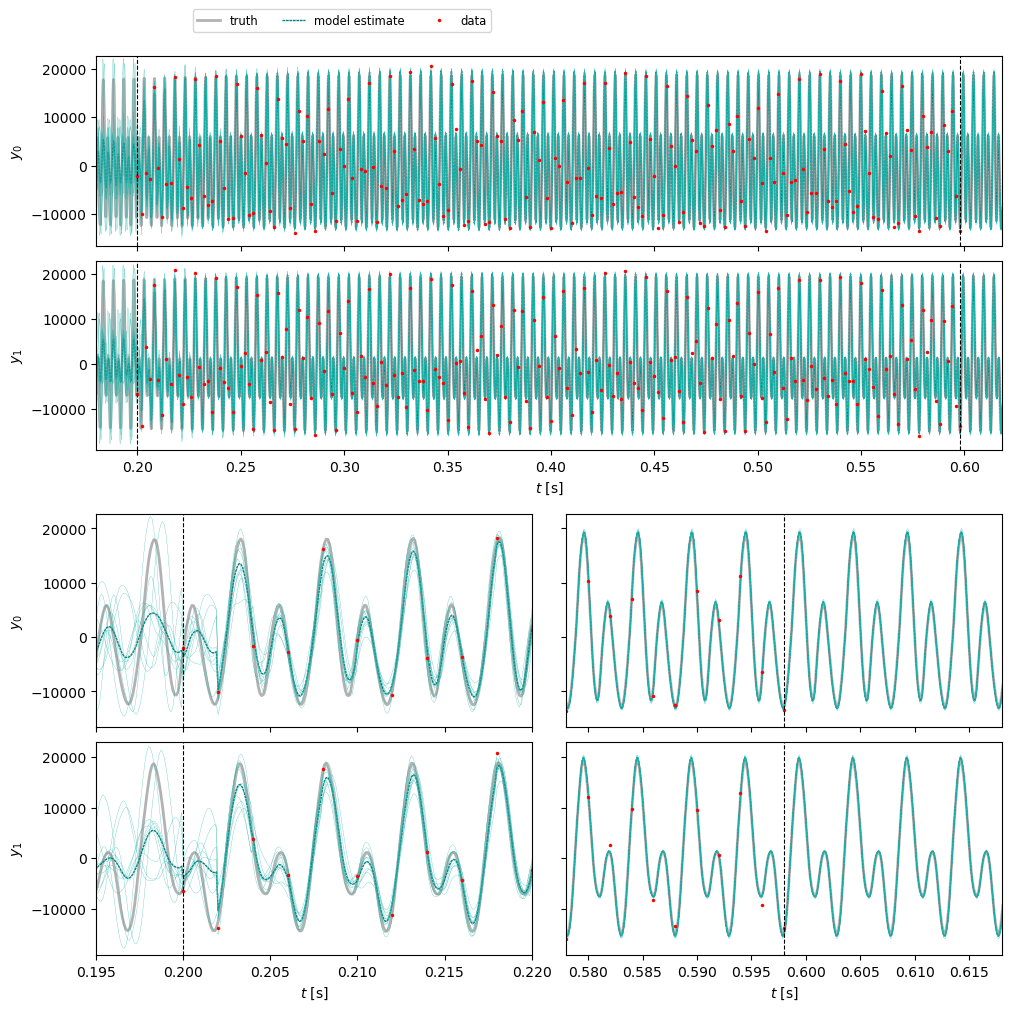

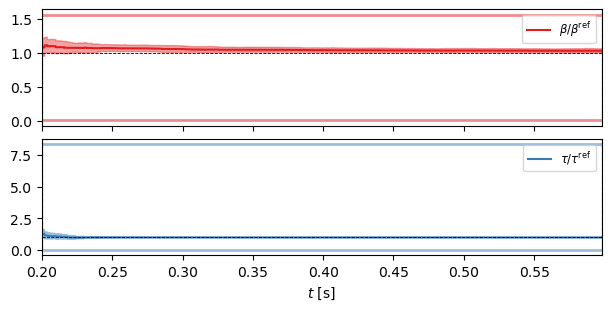

In [5]:
from src.plot_results import plot_parameters, plot_timeseries

plot_timeseries(filter_ens, truth, plot_ensemble_members=True,dims=[0,1])
plot_parameters(filter_ens, truth, reference_p=truth['true_params'])

